# Regression models

In [1]:
# Libraries
suppressPackageStartupMessages(library(tidyverse))
library(broom)
library(survival)
suppressPackageStartupMessages(library(survminer))

# Global
options(warn = -1)

# Scripts
source("summarize.R")

# Data
load("DF.Rdata")

glimpse(DF)

Observations: 411
Variables: 23
$ registry_id            <dbl> 20060035601, 19970063502, 20040008703, 2007008…
$ pt_stage               <fct> T1, T1, T2, T1, T1, T1, Tis, T1, T2, Ta, Ta, T…
$ sp_id                  <chr> "06-S-4802", "07-S-3788", "07-S-8931", "07-S-6…
$ ck56                   <dbl> 60, 10, 90, NA, NA, 5, NA, 0, 0, 40, NA, 40, 4…
$ ck20                   <dbl> 0, 0, 0, NA, 0, 70, NA, 80, 0, 0, NA, 0, 10, N…
$ cd44                   <dbl> 70, 60, NA, NA, NA, 40, NA, 5, NA, 60, NA, NA,…
$ gata3                  <dbl> 100, 100, 100, NA, 100, 100, NA, 100, 100, 100…
$ er                     <dbl> 40, 20, NA, NA, 0, 0, 0, 0, 0, 5, NA, NA, 0, N…
$ her2                   <dbl> 0, 5, NA, NA, 60, 30, NA, 40, 60, 60, NA, 30, …
$ uroplakin              <dbl> 5, 20, NA, NA, NA, 0, NA, 10, NA, 0, NA, NA, 0…
$ sex                    <fct> Male, Male, Male, Male, Male, Male, Female, Ma…
$ death                  <fct> Dead, Alive, Dead, Alive, Alive, Alive, Alive,…
$ progression_stage_

In [2]:
# A function to define which statistics (v.g., median, max value) will be used for summarizing biomarkers expression
# If needed, changing this function will update the approach for the entire analysis
summarize_biomarker <- function(x) { mean(x, na.rm = TRUE) }

# Tidying up the data and summarizing expression
OUTCOME <- DF %>% 
    group_by(sp_id) %>% 
    summarize(
        ck56 = summarize_biomarker(ck56),
        cd44 = summarize_biomarker(cd44),
        ck20 = summarize_biomarker(ck20),
        er = summarize_biomarker(er),
        her2 = summarize_biomarker(her2),
        gata3 = summarize_biomarker(gata3),
        uroplakin = summarize_biomarker(uroplakin),
        pt_stage = unique(pt_stage),
        fu_mo = unique(fu_mo),
        recurrence_next = unique(recurrence_next),
        recurrence_any = unique(recurrence_any),
        progression_grade_next = unique(progression_grade_next),
        progression_grade_any = unique(progression_grade_any),
        progression_stage_next = unique(progression_stage_next),
        progression_stage_any = unique(progression_stage_any)
    ) %>% 
    mutate(
        pt = ifelse(
          pt_stage == "Tis" | pt_stage == "Ta",
          "Low pT stage (<pT1)", "High pT stage (pT1-pT2)"
        ),
        pt = fct_relevel(pt, "Low pT stage (<pT1)"),
        ck56_level = ifelse(
          ck56 > summarize_biomarker(ck56),
          "High CK5/6 expression", "Low CK5/6 expression"
        ),
        ck56_level = fct_relevel(ck56_level, "Low CK5/6 expression"),
        cd44_level = ifelse(
          cd44 > summarize_biomarker(cd44),
          "High CD44 expression", "Low CD44 expression"
        ),
        cd44_level = fct_relevel(cd44_level, "Low CD44 expression"),
        ck20_level = ifelse(
          ck20 > summarize_biomarker(ck20),
          "High CK20 expression", "Low CK20 expression"
        ),
        ck20_level = fct_relevel(ck20_level, "Low CK20 expression"),
        er_level = ifelse(
          er > summarize_biomarker(er),
          "High ER expression", "Low ER expression"
        ),
        er_level = fct_relevel(er_level, "Low CK20 expression"),
        her2_level = ifelse(
          her2 > summarize_biomarker(her2),
          "High HER2 expression", "Low HER2 expression"
        ),
        her2_level = fct_relevel(her2_level, "Low HER2 expression"),
        gata3_level = ifelse(
          gata3 > summarize_biomarker(gata3),
          "High GATA3 expression", "Low GATA3 expression"
        ),
        gata3_level = fct_relevel(gata3_level, "Low GATA3 expression"),
        uroplakin_level = ifelse(
          uroplakin > summarize_biomarker(uroplakin),
          "High Uroplakin expression", "Low Uroplakin expression"
        ),
        uroplakin_level = fct_relevel(uroplakin_level, "Low Uroplakin expression")
    )

glimpse(OUTCOME)

Observations: 128
Variables: 24
$ sp_id                  <chr> "01-S-10015", "01-S-7500", "01-S-9347", "02-S-…
$ ck56                   <dbl> 5.000000, 3.333333, 10.000000, 11.000000, 15.0…
$ cd44                   <dbl> 30.000000, 15.000000, 43.333333, 26.000000, 38…
$ ck20                   <dbl> 10.000000, 23.333333, 30.000000, 25.000000, 76…
$ er                     <dbl> 0.0000000, 0.0000000, 0.0000000, 0.0000000, 0.…
$ her2                   <dbl> 36.666667, 0.000000, 18.333333, 1.666667, 50.0…
$ gata3                  <dbl> 100.00000, 100.00000, 100.00000, 100.00000, 10…
$ uroplakin              <dbl> 0.0000000, 0.0000000, 6.6666667, 6.6666667, 21…
$ pt_stage               <fct> Ta, Ta, Ta, T1, T1, T1, T1, T1, Ta, T1, Ta, Ta…
$ fu_mo                  <dbl> 85.2, 4.5, 85.2, 57.9, 57.9, 31.3, 31.3, 3.9, …
$ recurrence_next        <fct> No tumor recurrence, Tumor recurrence, Tumor r…
$ recurrence_any         <fct> Tumor recurrence, Tumor recurrence, Tumor recu…
$ progression_grade_

## CK5/6

In [3]:
OUTCOME <- OUTCOME %>% 
  mutate(biomarker_level = ck56_level)
OUTCOME %>% summarize_fct(biomarker_level)

# A tibble: 3 x 3
  Levels                    N  Freq
  <fct>                 <int> <dbl>
1 Low CK5/6 expression     70  54.7
2 High CK5/6 expression    47  36.7
3 <NA>                     11   8.6


### Tumor recurrence at next biopsy
#### Unadjusted

In [4]:
RN_marker <- OUTCOME %>% OR(recurrence_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.43      0.41      1.04   0.298  1.54     0.68      3.46


#### Adjusted by pT stage (low vs high)

In [5]:
OUTCOME %>% OR(recurrence_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.25      0.43     0.580   0.563  1.28     0.55      2.99
2 ptHigh pT stage…    -0.04      0.44    -0.09    0.929  0.96     0.4       2.28


### Tumor recurrence at any biopsy
#### Unadjusted

In [6]:
RA_marker <- OUTCOME %>% OR(recurrence_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.44      0.66      0.66   0.510  1.55     0.41      5.88


#### Adjusted by pT stage (low vs high)

In [7]:
OUTCOME %>% OR(recurrence_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.23      0.79     0.290  0.774   1.26     0.24      5.79
2 ptHigh pT stage…     1.31      0.78     1.68   0.0929  3.71     0.83     19.6 


### Tumor grade progression at next biopsy
#### Unadjusted

In [8]:
GN_marker <- OUTCOME %>% OR(progression_grade_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.02      0.94      0.03   0.979  1.02     0.16      8.04


#### Adjusted by pT stage (low vs high)

In [9]:
OUTCOME %>% OR(progression_grade_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term           estimate std.error statistic p.value      or conf.low conf.high
  <chr>             <dbl>     <dbl>     <dbl>   <dbl>   <dbl>    <dbl>     <dbl>
1 biomarker_lev…     0.24      0.95      0.25   0.799  1.27e0      0.2      10.2
2 ptHigh pT sta…    18.1    2913.        0.01   0.995  7.33e7      0        NA  


### Tumor grade progression at any biopsy
#### Unadjusted

In [10]:
GA_marker <- OUTCOME %>% OR(progression_grade_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.07      0.62     -0.11   0.911  0.93     0.28      3.34


#### Adjusted by pT stage (low vs high)

In [11]:
OUTCOME %>% OR(progression_grade_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.26      0.67      0.39   0.698  1.3      0.36      5.32
2 ptHigh pT stage…     0.98      0.82      1.19   0.233  2.66     0.63     18.3 


### Tumor stage progression at next biopsy
#### Unadjusted

In [12]:
SN_marker <- OUTCOME %>% OR(progression_stage_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -1.78      1.14     -1.57   0.117  0.17     0.01      1.19


#### Adjusted by pT stage (low vs high)

In [13]:
OUTCOME %>% OR(progression_stage_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -2.21      1.18     -1.88  0.0606  0.11     0.01      0.84
2 ptHigh pT stage…    -1.52      0.99     -1.54  0.123   0.22     0.03      1.49


### Tumor stage progression at any biopsy
#### Unadjusted

In [14]:
SA_marker <- OUTCOME %>% OR(progression_stage_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.17      0.54     -0.31   0.753  0.84    0.290      2.53


#### Adjusted by pT stage (low vs high)

In [15]:
OUTCOME %>% OR(progression_stage_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -1.12      0.68     -1.65 9.96e-2  0.33     0.08      1.21
2 ptHigh pT stage…    -3.36      0.85     -3.97 7.15e-5  0.03     0         0.15


### Summary table

In [16]:
# Strings for outcomes
outcomes_str <- c(
    "Tumor recurrence at next biopsy diagnosis",
    "Tumor recurrence at any subsequent biopsy diagnosis",
    "Tumor grade progression at next biopsy diagnosis",
    "Tumor grade progression at any subsequent biopsy diagnosis",
    "Tumor stage progression at next biopsy diagnosis",
    "Tumor stage progression at any subsequent biopsy diagnosis"
)

# OR table for CK5/6
OR_ck56 <- bind_rows(
    RN_marker,
    RA_marker,
    GN_marker,
    GA_marker,
    SN_marker,
    SA_marker
    ) %>% 
    mutate(
        outcome = outcomes_str,
        marker = c("CK5/6"),
        p.value = formatC(p.value, digits = 2, format = "fg", flag = "#"),
        conf.low = formatC(conf.low, digits = 3),
        conf.high = formatC(conf.high, digits = 3)
    ) %>% 
    select(
        marker, outcome, or, conf.low, conf.high, p.value
    ) 

OR_ck56

marker,outcome,or,conf.low,conf.high,p.value
CK5/6,Tumor recurrence at next biopsy diagnosis,1.54,0.68,3.46,0.30
CK5/6,Tumor recurrence at any subsequent biopsy diagnosis,1.55,0.41,5.88,0.51
CK5/6,Tumor grade progression at next biopsy diagnosis,1.02,0.16,8.04,0.98
CK5/6,Tumor grade progression at any subsequent biopsy diagnosis,0.93,0.28,3.34,0.91
CK5/6,Tumor stage progression at next biopsy diagnosis,0.17,0.01,1.19,0.12
CK5/6,Tumor stage progression at any subsequent biopsy diagnosis,0.84,0.29,2.53,0.75


## CD44

In [17]:
OUTCOME <- OUTCOME %>% 
  mutate(biomarker_level = cd44_level)
OUTCOME %>% summarize_fct(biomarker_level)

# A tibble: 3 x 3
  Levels                   N  Freq
  <fct>                <int> <dbl>
1 Low CD44 expression     57  44.5
2 High CD44 expression    57  44.5
3 <NA>                    14  10.9


### Tumor recurrence at next biopsy
#### Unadjusted

In [18]:
RN_marker <- OUTCOME %>% OR(recurrence_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.92      0.42      2.16  0.0308  2.51      1.1      5.85


#### Adjusted by pT stage (low vs high)

In [19]:
OUTCOME %>% OR(recurrence_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.8       0.44     1.79   0.0734  2.23     0.94      5.4 
2 ptHigh pT stage…    -0.13      0.47    -0.290  0.773   0.88     0.34      2.17


### Tumor recurrence at any biopsy
#### Unadjusted

In [20]:
RA_marker <- OUTCOME %>% OR(recurrence_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.92      0.72      1.29   0.198  2.51     0.66      12.2


#### Adjusted by pT stage (low vs high)

In [21]:
OUTCOME %>% OR(recurrence_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.87      0.78      1.1   0.270   2.39     0.53      12.8
2 ptHigh pT stage…     1.44      0.78      1.84  0.0657  4.22     0.94      22.4


### Tumor grade progression at next biopsy
#### Unadjusted

In [22]:
GN_marker <- OUTCOME %>% OR(progression_grade_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.69      1.24      0.56   0.576  1.99     0.19      43.8


#### Adjusted by pT stage (low vs high)

In [23]:
OUTCOME %>% OR(progression_grade_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term           estimate std.error statistic p.value      or conf.low conf.high
  <chr>             <dbl>     <dbl>     <dbl>   <dbl>   <dbl>    <dbl>     <dbl>
1 biomarker_lev…     0.89      1.25      0.71   0.475  2.44e0     0.22      54.3
2 ptHigh pT sta…    17.7    2966.        0.01   0.995  4.82e7     0         NA  


### Tumor grade progression at any biopsy
#### Unadjusted

In [24]:
GA_marker <- OUTCOME %>% OR(progression_grade_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.44      0.67     -0.66   0.511  0.64     0.16      2.38


#### Adjusted by pT stage (low vs high)

In [25]:
OUTCOME %>% OR(progression_grade_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.15      0.71     -0.2    0.838  0.86     0.2       3.53
2 ptHigh pT stage…     1.48      1.09      1.36   0.173  4.39     0.75     83.7 


### Tumor stage progression at next biopsy
#### Unadjusted

In [26]:
SN_marker <- OUTCOME %>% OR(progression_stage_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.45      0.94      0.48   0.632  1.57     0.25      12.3


#### Adjusted by pT stage (low vs high)

In [27]:
OUTCOME %>% OR(progression_stage_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.24      0.95      0.25   0.804  1.27     0.19     10.2 
2 ptHigh pT stage…    -1.05      0.95     -1.1    0.270  0.35     0.04      2.26


### Tumor stage progression at any biopsy
#### Unadjusted

In [28]:
SA_marker <- OUTCOME %>% OR(progression_stage_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.79     0.580      1.36   0.173   2.2     0.73      7.54


#### Adjusted by pT stage (low vs high)

In [29]:
OUTCOME %>% OR(progression_stage_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.41      0.65      0.64 5.25e-1  1.51     0.43      5.73
2 ptHigh pT stage…    -2.89      0.8      -3.62 3.00e-4  0.06     0.01      0.22


### Summary table

In [30]:
# OR table for CD44
OR_cd44 <- bind_rows(
    RN_marker,
    RA_marker,
    GN_marker,
    GA_marker,
    SN_marker,
    SA_marker
    ) %>% 
    mutate(
        outcome = outcomes_str,
        marker = c("CD44"),
        p.value = formatC(p.value, digits = 2, format = "fg", flag = "#"),
        conf.low = formatC(conf.low, digits = 3),
        conf.high = formatC(conf.high, digits = 3)
    ) %>% 
    select(
        marker, outcome, or, conf.low, conf.high, p.value
    ) 

OR_cd44

marker,outcome,or,conf.low,conf.high,p.value
CD44,Tumor recurrence at next biopsy diagnosis,2.51,1.1,5.85,0.031
CD44,Tumor recurrence at any subsequent biopsy diagnosis,2.51,0.66,12.2,0.20
CD44,Tumor grade progression at next biopsy diagnosis,1.99,0.19,43.9,0.58
CD44,Tumor grade progression at any subsequent biopsy diagnosis,0.64,0.16,2.38,0.51
CD44,Tumor stage progression at next biopsy diagnosis,1.57,0.25,12.3,0.63
CD44,Tumor stage progression at any subsequent biopsy diagnosis,2.20,0.73,7.54,0.17


## CK20

In [31]:
OUTCOME <- OUTCOME %>% 
  mutate(biomarker_level = ck20_level)
OUTCOME %>% summarize_fct(biomarker_level)

# A tibble: 3 x 3
  Levels                   N  Freq
  <fct>                <int> <dbl>
1 Low CK20 expression     67  52.3
2 High CK20 expression    49  38.3
3 <NA>                    12   9.4


### Tumor recurrence at next biopsy
#### Unadjusted

In [32]:
RN_marker <- OUTCOME %>% OR(recurrence_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.15      0.42     -0.35   0.726  0.86     0.38      1.95


#### Adjusted by pT stage (low vs high)

In [33]:
OUTCOME %>% OR(recurrence_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.02      0.42     -0.04   0.965  0.98     0.42      2.25
2 ptHigh pT stage…    -0.04      0.44     -0.09   0.925  0.96     0.4       2.24


### Tumor recurrence at any biopsy
#### Unadjusted

In [34]:
RA_marker <- OUTCOME %>% OR(recurrence_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…   -0.580      0.72     -0.81   0.418  0.56     0.12      2.13


#### Adjusted by pT stage (low vs high)

In [35]:
OUTCOME %>% OR(recurrence_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     -0.3      0.77     -0.39  0.699   0.74     0.14      3.26
2 ptHigh pT stage…      1.3      0.76      1.71  0.0878  3.67     0.85     18.8 


### Tumor grade progression at next biopsy
#### Unadjusted

In [36]:
GN_marker <- OUTCOME %>% OR(progression_grade_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.81      0.94     -0.87   0.386  0.44     0.06       2.8


#### Adjusted by pT stage (low vs high)

In [37]:
OUTCOME %>% OR(progression_grade_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term          estimate std.error statistic p.value       or conf.low conf.high
  <chr>            <dbl>     <dbl>     <dbl>   <dbl>    <dbl>    <dbl>     <dbl>
1 biomarker_le…    -0.77      0.95     -0.81   0.417  4.60e-1     0.06      2.99
2 ptHigh pT st…    18.0    2926.        0.01   0.995  6.90e+7     0        NA   


### Tumor grade progression at any biopsy
#### Unadjusted

In [38]:
GA_marker <- OUTCOME %>% OR(progression_grade_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.35      0.61    -0.570   0.567   0.7     0.21      2.39


#### Adjusted by pT stage (low vs high)

In [39]:
OUTCOME %>% OR(progression_grade_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.52      0.64     -0.81   0.418  0.59     0.16      2.11
2 ptHigh pT stage…     0.91      0.81      1.13   0.260  2.48     0.6      17.0 


### Tumor stage progression at next biopsy
#### Unadjusted

In [40]:
SN_marker <- OUTCOME %>% OR(progression_stage_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…      0.7      1.17       0.6   0.550  2.01     0.25      41.6


#### Adjusted by pT stage (low vs high)

In [41]:
OUTCOME %>% OR(progression_stage_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.76      1.18      0.65   0.517  2.14     0.26     44.3 
2 ptHigh pT stage…    -0.67      1.03     -0.65   0.515  0.51     0.06      4.45


### Tumor stage progression at any biopsy
#### Unadjusted

In [42]:
SA_marker <- OUTCOME %>% OR(progression_stage_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.79      0.62      1.28   0.199   2.2      0.7       8.4


#### Adjusted by pT stage (low vs high)

In [43]:
OUTCOME %>% OR(progression_stage_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     1.11      0.68      1.62 1.05e-1  3.03     0.84     12.8 
2 ptHigh pT stage…    -3.05      0.81     -3.77 1.61e-4  0.05     0.01      0.19


### Summary table

In [44]:
# OR table for CK20
OR_ck20 <- bind_rows(
    RN_marker,
    RA_marker,
    GN_marker,
    GA_marker,
    SN_marker,
    SA_marker
    ) %>% 
    mutate(
        outcome = outcomes_str,
        marker = c("CK20"),
        p.value = formatC(p.value, digits = 2, format = "fg", flag = "#"),
        conf.low = formatC(conf.low, digits = 3),
        conf.high = formatC(conf.high, digits = 3)
    ) %>% 
    select(
        marker, outcome, or, conf.low, conf.high, p.value
    ) 

OR_ck20

marker,outcome,or,conf.low,conf.high,p.value
CK20,Tumor recurrence at next biopsy diagnosis,0.86,0.38,1.95,0.73
CK20,Tumor recurrence at any subsequent biopsy diagnosis,0.56,0.12,2.13,0.42
CK20,Tumor grade progression at next biopsy diagnosis,0.44,0.06,2.8,0.39
CK20,Tumor grade progression at any subsequent biopsy diagnosis,0.70,0.21,2.39,0.57
CK20,Tumor stage progression at next biopsy diagnosis,2.01,0.25,41.6,0.55
CK20,Tumor stage progression at any subsequent biopsy diagnosis,2.20,0.7,8.4,0.20


## ER

In [45]:
OUTCOME <- OUTCOME %>% 
  mutate(biomarker_level = er_level)
OUTCOME %>% summarize_fct(biomarker_level)

# A tibble: 3 x 3
  Levels                 N  Freq
  <fct>              <int> <dbl>
1 High ER expression    19  14.8
2 Low ER expression     99  77.3
3 <NA>                  10   7.8


### Tumor recurrence at next biopsy
#### Unadjusted

In [46]:
RN_marker <- OUTCOME %>% OR(recurrence_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.12      0.54     -0.22   0.828  0.89     0.31      2.66


#### Adjusted by pT stage (low vs high)

In [47]:
OUTCOME %>% OR(recurrence_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.14      0.6      0.23    0.814  1.15     0.37      3.99
2 ptHigh pT stage…    -0.13      0.44    -0.290   0.770  0.88     0.36      2.07


### Tumor recurrence at any biopsy
#### Unadjusted

In [48]:
RA_marker <- OUTCOME %>% OR(recurrence_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -1.42       0.7     -2.02  0.0435  0.24     0.06      1.04


#### Adjusted by pT stage (low vs high)

In [49]:
OUTCOME %>% OR(recurrence_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -1.3       0.8      -1.62   0.106  0.27     0.06      1.49
2 ptHigh pT stage…     1.25      0.77      1.62   0.105  3.49     0.79     18.1 


### Tumor grade progression at next biopsy
#### Unadjusted

In [50]:
GN_marker <- OUTCOME %>% OR(progression_grade_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -16.7     2535.     -0.01   0.995     0       NA  8.74e112


#### Adjusted by pT stage (low vs high)

In [51]:
OUTCOME %>% OR(progression_grade_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term           estimate std.error statistic p.value      or conf.low conf.high
  <chr>             <dbl>     <dbl>     <dbl>   <dbl>   <dbl>    <dbl>     <dbl>
1 biomarker_lev…    -17.4     4057.      0      0.997  0.           NA  4.83e183
2 ptHigh pT sta…     17.9     2854.      0.01   0.995  6.06e7        0 NA       


### Tumor grade progression at any biopsy
#### Unadjusted

In [52]:
GA_marker <- OUTCOME %>% OR(progression_grade_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.16      0.83       0.2   0.844  1.17     0.17      5.09


#### Adjusted by pT stage (low vs high)

In [53]:
OUTCOME %>% OR(progression_grade_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.39      1.1      -0.36   0.721  0.68     0.03      4.12
2 ptHigh pT stage…     1.59      1.07      1.48   0.140  4.9      0.87     92.0 


### Tumor stage progression at next biopsy
#### Unadjusted

In [54]:
SN_marker <- OUTCOME %>% OR(progression_stage_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -16.8     2688.     -0.01   0.995     0       NA  1.52e120


#### Adjusted by pT stage (low vs high)

In [55]:
OUTCOME %>% OR(progression_stage_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…   -16.9    2806.       -0.01   0.995   0      NA     2.34e125
2 ptHigh pT stage…    -1.19      0.94     -1.26   0.206   0.3     0.04  1.94e  0


### Tumor stage progression at any biopsy
#### Unadjusted

In [56]:
SA_marker <- OUTCOME %>% OR(progression_stage_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.25       0.8     -0.31   0.755  0.78     0.12      3.17


#### Adjusted by pT stage (low vs high)

In [57]:
OUTCOME %>% OR(progression_stage_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.47      0.88     -0.53 5.94e-1  0.63     0.08      3.08
2 ptHigh pT stage…    -2.99      0.8      -3.75 1.79e-4  0.05     0.01      0.2 


### Summary table

In [58]:
# OR table for CK5/6
OR_er <- bind_rows(
    RN_marker,
    RA_marker,
    GN_marker,
    GA_marker,
    SN_marker,
    SA_marker
    ) %>% 
    mutate(
        outcome = outcomes_str,
        marker = c("ER"),
        p.value = formatC(p.value, digits = 2, format = "fg", flag = "#"),
        conf.low = formatC(conf.low, digits = 3),
        conf.high = formatC(conf.high, digits = 3)
    ) %>% 
    select(
        marker, outcome, or, conf.low, conf.high, p.value
    ) 

OR_er

marker,outcome,or,conf.low,conf.high,p.value
ER,Tumor recurrence at next biopsy diagnosis,0.89,0.31,2.66,0.83
ER,Tumor recurrence at any subsequent biopsy diagnosis,0.24,0.06,1.04,0.044
ER,Tumor grade progression at next biopsy diagnosis,0.00,NA,8.74e+112,0.99
ER,Tumor grade progression at any subsequent biopsy diagnosis,1.17,0.17,5.09,0.84
ER,Tumor stage progression at next biopsy diagnosis,0.00,NA,1.52e+120,1.0
ER,Tumor stage progression at any subsequent biopsy diagnosis,0.78,0.12,3.17,0.76


## HER2

In [59]:
OUTCOME <- OUTCOME %>% 
  mutate(biomarker_level = her2_level)
OUTCOME %>% summarize_fct(biomarker_level)

# A tibble: 3 x 3
  Levels                   N  Freq
  <fct>                <int> <dbl>
1 Low HER2 expression     64  50  
2 High HER2 expression    53  41.4
3 <NA>                    11   8.6


### Tumor recurrence at next biopsy
#### Unadjusted

In [60]:
RN_marker <- OUTCOME %>% OR(recurrence_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.31      0.41     -0.77   0.444  0.73     0.33      1.62


#### Adjusted by pT stage (low vs high)

In [61]:
OUTCOME %>% OR(recurrence_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.12      0.42     -0.27   0.784  0.89     0.39      2.04
2 ptHigh pT stage…    -0.09      0.44     -0.21   0.834  0.91     0.38      2.15


### Tumor recurrence at any biopsy
#### Unadjusted

In [62]:
RA_marker <- OUTCOME %>% OR(recurrence_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -1.29      0.81     -1.59   0.112  0.28     0.04      1.16


#### Adjusted by pT stage (low vs high)

In [63]:
OUTCOME %>% OR(recurrence_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -1.35      0.87     -1.56  0.120   0.26     0.04      1.25
2 ptHigh pT stage…     1.51      0.79      1.92  0.0548  4.53     1        24.3 


### Tumor grade progression at next biopsy
#### Unadjusted

In [64]:
GN_marker <- OUTCOME %>% OR(progression_grade_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -1.65      1.14     -1.45   0.147  0.19     0.01      1.36


#### Adjusted by pT stage (low vs high)

In [65]:
OUTCOME %>% OR(progression_grade_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term          estimate std.error statistic p.value       or conf.low conf.high
  <chr>            <dbl>     <dbl>     <dbl>   <dbl>    <dbl>    <dbl>     <dbl>
1 biomarker_le…    -1.93      1.15     -1.68  0.0927  1.50e-1     0.01      1.05
2 ptHigh pT st…    18.4    2796.        0.01  0.995   9.32e+7     0        NA   


### Tumor grade progression at any biopsy
#### Unadjusted

In [66]:
GA_marker <- OUTCOME %>% OR(progression_grade_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -1.43       0.7     -2.05  0.0404  0.24     0.05      0.86


#### Adjusted by pT stage (low vs high)

In [67]:
OUTCOME %>% OR(progression_grade_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -1.99      0.82     -2.43  0.0153  0.14     0.02     0.580
2 ptHigh pT stage…     1.3       0.83      1.57  0.118   3.67     0.84    25.8  


### Tumor stage progression at next biopsy
#### Unadjusted

In [68]:
SN_marker <- OUTCOME %>% OR(progression_stage_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.63      0.94     -0.68   0.498  0.53     0.07      3.34


#### Adjusted by pT stage (low vs high)

In [69]:
OUTCOME %>% OR(progression_stage_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.41      0.95     -0.43   0.668  0.66     0.08      4.34
2 ptHigh pT stage…    -0.99      0.95     -1.04   0.298  0.37     0.05      2.41


### Tumor stage progression at any biopsy
#### Unadjusted

In [70]:
SA_marker <- OUTCOME %>% OR(progression_stage_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.51      0.54     -0.94   0.347   0.6      0.2      1.74


#### Adjusted by pT stage (low vs high)

In [71]:
OUTCOME %>% OR(progression_stage_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.03      0.62      0.04 9.67e-1  1.03     0.3       3.47
2 ptHigh pT stage…    -3.01      0.8      -3.76 1.67e-4  0.05     0.01      0.2 


### Summary table

In [72]:
# OR table for CK5/6
OR_her2 <- bind_rows(
    RN_marker,
    RA_marker,
    GN_marker,
    GA_marker,
    SN_marker,
    SA_marker
    ) %>% 
    mutate(
        outcome = outcomes_str,
        marker = c("HER2/neu"),
        p.value = formatC(p.value, digits = 2, format = "fg", flag = "#"),
        conf.low = formatC(conf.low, digits = 3),
        conf.high = formatC(conf.high, digits = 3)
    ) %>% 
    select(
        marker, outcome, or, conf.low, conf.high, p.value
    ) 

OR_her2

marker,outcome,or,conf.low,conf.high,p.value
HER2/neu,Tumor recurrence at next biopsy diagnosis,0.73,0.33,1.62,0.44
HER2/neu,Tumor recurrence at any subsequent biopsy diagnosis,0.28,0.04,1.16,0.11
HER2/neu,Tumor grade progression at next biopsy diagnosis,0.19,0.01,1.36,0.15
HER2/neu,Tumor grade progression at any subsequent biopsy diagnosis,0.24,0.05,0.86,0.040
HER2/neu,Tumor stage progression at next biopsy diagnosis,0.53,0.07,3.34,0.50
HER2/neu,Tumor stage progression at any subsequent biopsy diagnosis,0.60,0.2,1.74,0.35


## GATA3

In [73]:
OUTCOME <- OUTCOME %>% 
  mutate(biomarker_level = gata3_level)
OUTCOME %>% summarize_fct(biomarker_level)

# A tibble: 3 x 3
  Levels                    N  Freq
  <fct>                 <int> <dbl>
1 Low GATA3 expression      9   7  
2 High GATA3 expression   108  84.4
3 <NA>                     11   8.6


### Tumor recurrence at next biopsy
#### Unadjusted

In [74]:
RN_marker <- OUTCOME %>% OR(recurrence_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.08      0.76       0.1   0.918  1.08     0.25      5.53


#### Adjusted by pT stage (low vs high)

In [75]:
OUTCOME %>% OR(recurrence_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.09      0.77     -0.11   0.911  0.91     0.21      4.79
2 ptHigh pT stage…    -0.17      0.45     -0.39   0.698  0.84     0.34      2   


### Tumor recurrence at any biopsy
#### Unadjusted

In [76]:
RA_marker <- OUTCOME %>% OR(recurrence_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.32      1.12    -0.290   0.775  0.73     0.11      14.3


#### Adjusted by pT stage (low vs high)

In [77]:
OUTCOME %>% OR(recurrence_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.26      1.16     -0.23  0.821   0.77     0.11      15.8
2 ptHigh pT stage…     1.27      0.77      1.65  0.0979  3.56     0.81      18.4


### Tumor grade progression at next biopsy
#### Unadjusted

In [78]:
GN_marker <- OUTCOME %>% OR(progression_grade_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -15.6     2174.     -0.01   0.994     0       NA   2.77e96


#### Adjusted by pT stage (low vs high)

In [79]:
OUTCOME %>% OR(progression_grade_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term            estimate std.error statistic p.value     or conf.low conf.high
  <chr>              <dbl>     <dbl>     <dbl>   <dbl>  <dbl>    <dbl>     <dbl>
1 biomarker_leve…    -17.1     5265.      0      0.997 0.           NA  3.15e251
2 ptHigh pT stag…     17.9     2886.      0.01   0.995 6.18e7        0 NA       


### Tumor grade progression at any biopsy
#### Unadjusted

In [80]:
GA_marker <- OUTCOME %>% OR(progression_grade_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -16.4     2174.     -0.01   0.994     0       NA   1.04e68


#### Adjusted by pT stage (low vs high)

In [81]:
OUTCOME %>% OR(progression_grade_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…   -16.0    2095.       -0.01   0.994  0       NA      1.92e88
2 ptHigh pT stage…     1.54      1.08      1.43   0.154  4.66     0.82   8.76e 1


### Tumor stage progression at next biopsy
#### Unadjusted

In [82]:
SN_marker <- OUTCOME %>% OR(progression_stage_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     1.17      1.18      0.99   0.324  3.22     0.15      25.8


#### Adjusted by pT stage (low vs high)

In [83]:
OUTCOME %>% OR(progression_stage_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.84      1.22      0.69   0.488  2.32     0.11     20.0 
2 ptHigh pT stage…    -0.99      0.96     -1.03   0.302  0.37     0.05      2.48


### Tumor stage progression at any biopsy
#### Unadjusted

In [84]:
SA_marker <- OUTCOME %>% OR(progression_stage_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.74      0.85      0.86   0.389   2.1    0.290      9.81


#### Adjusted by pT stage (low vs high)

In [85]:
OUTCOME %>% OR(progression_stage_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.17      0.94      0.18 8.60e-1  1.19     0.15      6.97
2 ptHigh pT stage…    -2.93      0.8      -3.68 2.37e-4  0.05     0.01      0.21


### Summary table

In [86]:
# OR table for CK5/6
OR_gata3 <- bind_rows(
    RN_marker,
    RA_marker,
    GN_marker,
    GA_marker,
    SN_marker,
    SA_marker
    ) %>% 
    mutate(
        outcome = outcomes_str,
        marker = c("GATA3"),
        p.value = formatC(p.value, digits = 2, format = "fg", flag = "#"),
        conf.low = formatC(conf.low, digits = 3),
        conf.high = formatC(conf.high, digits = 3)
    ) %>% 
    select(
        marker, outcome, or, conf.low, conf.high, p.value
    ) 

OR_gata3

marker,outcome,or,conf.low,conf.high,p.value
GATA3,Tumor recurrence at next biopsy diagnosis,1.08,0.25,5.53,0.92
GATA3,Tumor recurrence at any subsequent biopsy diagnosis,0.73,0.11,14.3,0.78
GATA3,Tumor grade progression at next biopsy diagnosis,0.00,NA,2.77e+96,0.99
GATA3,Tumor grade progression at any subsequent biopsy diagnosis,0.00,NA,1.04e+68,0.99
GATA3,Tumor stage progression at next biopsy diagnosis,3.22,0.15,25.8,0.32
GATA3,Tumor stage progression at any subsequent biopsy diagnosis,2.10,0.29,9.81,0.39


## Uroplakin

In [87]:
OUTCOME <- OUTCOME %>% 
  mutate(biomarker_level = uroplakin_level)
OUTCOME %>% summarize_fct(biomarker_level)

# A tibble: 3 x 3
  Levels                        N  Freq
  <fct>                     <int> <dbl>
1 Low Uroplakin expression     83  64.8
2 High Uroplakin expression    32  25  
3 <NA>                         13  10.2


### Tumor recurrence at next biopsy
#### Unadjusted

In [88]:
RN_marker <- OUTCOME %>% OR(recurrence_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.61      0.46     -1.31   0.191  0.54     0.21      1.32


#### Adjusted by pT stage (low vs high)

In [89]:
OUTCOME %>% OR(recurrence_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.44      0.47     -0.92   0.358  0.64     0.25      1.61
2 ptHigh pT stage…    -0.19      0.46     -0.43   0.671  0.83     0.33      1.99


### Tumor recurrence at any biopsy
#### Unadjusted

In [90]:
RA_marker <- OUTCOME %>% OR(recurrence_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.12      0.72      0.16   0.873  1.13     0.23      4.34


#### Adjusted by pT stage (low vs high)

In [91]:
OUTCOME %>% OR(recurrence_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.24      0.78      0.3   0.761   1.27     0.24      5.69
2 ptHigh pT stage…     1.28      0.77      1.66  0.0968  3.6      0.82     18.5 


### Tumor grade progression at next biopsy
#### Unadjusted

In [92]:
GN_marker <- OUTCOME %>% OR(progression_grade_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -1.35      0.94     -1.44   0.151  0.26     0.03      1.64


#### Adjusted by pT stage (low vs high)

In [93]:
OUTCOME %>% OR(progression_grade_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term           estimate std.error statistic p.value      or conf.low conf.high
  <chr>             <dbl>     <dbl>     <dbl>   <dbl>   <dbl>    <dbl>     <dbl>
1 biomarker_lev…    -1.62      0.96     -1.68  0.0930 2.00e-1     0.02      1.31
2 ptHigh pT sta…    18.3    2876.        0.01  0.995  8.77e+7     0        NA   


### Tumor grade progression at any biopsy
#### Unadjusted

In [94]:
GA_marker <- OUTCOME %>% OR(progression_grade_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.03      0.71      0.04   0.966  1.03     0.28      4.95


#### Adjusted by pT stage (low vs high)

In [95]:
OUTCOME %>% OR(progression_grade_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.25      0.74     -0.33   0.739  0.78     0.19       3.9
2 ptHigh pT stage…     1.64      1.08      1.52   0.129  5.16     0.9       97.9


### Tumor stage progression at next biopsy
#### Unadjusted

In [96]:
SN_marker <- OUTCOME %>% OR(progression_stage_next ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.48      0.94     -0.51   0.608  0.62      0.1      4.88


#### Adjusted by pT stage (low vs high)

In [97]:
OUTCOME %>% OR(progression_stage_next ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…    -0.27      0.96     -0.28   0.778  0.76     0.12      6.2 
2 ptHigh pT stage…    -1.1       0.95     -1.16   0.248  0.33     0.04      2.15


### Tumor stage progression at any biopsy
#### Unadjusted

In [98]:
SA_marker <- OUTCOME %>% OR(progression_stage_any ~ biomarker_level)

# A tibble: 1 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     -0.3      0.59     -0.51   0.611  0.74     0.24      2.55


#### Adjusted by pT stage (low vs high)

In [99]:
OUTCOME %>% OR(progression_stage_any ~ biomarker_level + pt)

# A tibble: 2 x 8
  term             estimate std.error statistic p.value    or conf.low conf.high
  <chr>               <dbl>     <dbl>     <dbl>   <dbl> <dbl>    <dbl>     <dbl>
1 biomarker_level…     0.18      0.66      0.26 7.91e-1  1.2      0.34      4.66
2 ptHigh pT stage…    -3         0.8      -3.74 1.87e-4  0.05     0.01      0.2 


### Summary table

In [100]:
# OR table for CK5/6
OR_uroplakin <- bind_rows(
    RN_marker,
    RA_marker,
    GN_marker,
    GA_marker,
    SN_marker,
    SA_marker
    ) %>% 
    mutate(
        outcome = outcomes_str,
        marker = c("Uroplakin II"),
        p.value = formatC(p.value, digits = 2, format = "fg", flag = "#"),
        conf.low = formatC(conf.low, digits = 3),
        conf.high = formatC(conf.high, digits = 3)
    ) %>% 
    select(
        marker, outcome, or, conf.low, conf.high, p.value
    ) 

OR_uroplakin

marker,outcome,or,conf.low,conf.high,p.value
Uroplakin II,Tumor recurrence at next biopsy diagnosis,0.54,0.21,1.32,0.19
Uroplakin II,Tumor recurrence at any subsequent biopsy diagnosis,1.13,0.23,4.34,0.87
Uroplakin II,Tumor grade progression at next biopsy diagnosis,0.26,0.03,1.64,0.15
Uroplakin II,Tumor grade progression at any subsequent biopsy diagnosis,1.03,0.28,4.95,0.97
Uroplakin II,Tumor stage progression at next biopsy diagnosis,0.62,0.1,4.88,0.61
Uroplakin II,Tumor stage progression at any subsequent biopsy diagnosis,0.74,0.24,2.55,0.61


## Summary OR table

In [101]:
summary_OR <- bind_rows(
    OR_ck56,
    OR_cd44,
    OR_ck20,
    OR_er,
    OR_her2,
    OR_gata3,
    OR_uroplakin
)

### Tumor recurrence at next biopsy

In [102]:
summary_OR %>% 
  filter(outcome == "Tumor recurrence at next biopsy diagnosis") %>% 
  select(-outcome)

marker,or,conf.low,conf.high,p.value
CK5/6,1.54,0.68,3.46,0.30
CD44,2.51,1.1,5.85,0.031
CK20,0.86,0.38,1.95,0.73
ER,0.89,0.31,2.66,0.83
HER2/neu,0.73,0.33,1.62,0.44
GATA3,1.08,0.25,5.53,0.92
Uroplakin II,0.54,0.21,1.32,0.19


### Tumor recurrence at any biopsy

In [103]:
summary_OR %>% 
  filter(outcome == "Tumor recurrence at any subsequent biopsy diagnosis") %>% 
  select(-outcome)

marker,or,conf.low,conf.high,p.value
CK5/6,1.55,0.41,5.88,0.51
CD44,2.51,0.66,12.2,0.20
CK20,0.56,0.12,2.13,0.42
ER,0.24,0.06,1.04,0.044
HER2/neu,0.28,0.04,1.16,0.11
GATA3,0.73,0.11,14.3,0.78
Uroplakin II,1.13,0.23,4.34,0.87


### Tumor grade progression at next biopsy

In [104]:
summary_OR %>% 
  filter(outcome == "Tumor grade progression at next biopsy diagnosis") %>% 
  select(-outcome)

marker,or,conf.low,conf.high,p.value
CK5/6,1.02,0.16,8.04,0.98
CD44,1.99,0.19,43.9,0.58
CK20,0.44,0.06,2.8,0.39
ER,0.00,NA,8.74e+112,0.99
HER2/neu,0.19,0.01,1.36,0.15
GATA3,0.00,NA,2.77e+96,0.99
Uroplakin II,0.26,0.03,1.64,0.15


### Tumor grade progression at any biopsy

In [105]:
summary_OR %>% 
  filter(outcome == "Tumor grade progression at any subsequent biopsy diagnosis") %>% 
  select(-outcome)

marker,or,conf.low,conf.high,p.value
CK5/6,0.93,0.28,3.34,0.91
CD44,0.64,0.16,2.38,0.51
CK20,0.70,0.21,2.39,0.57
ER,1.17,0.17,5.09,0.84
HER2/neu,0.24,0.05,0.86,0.040
GATA3,0.00,NA,1.04e+68,0.99
Uroplakin II,1.03,0.28,4.95,0.97


### Tumor stage progression at next biopsy

In [106]:
summary_OR %>% 
  filter(outcome == "Tumor stage progression at next biopsy diagnosis") %>% 
  select(-outcome)

marker,or,conf.low,conf.high,p.value
CK5/6,0.17,0.01,1.19,0.12
CD44,1.57,0.25,12.3,0.63
CK20,2.01,0.25,41.6,0.55
ER,0.00,NA,1.52e+120,1.0
HER2/neu,0.53,0.07,3.34,0.50
GATA3,3.22,0.15,25.8,0.32
Uroplakin II,0.62,0.1,4.88,0.61


### Tumor stage progression at any biopsy

In [107]:
summary_OR %>% 
  filter(outcome == "Tumor stage progression at any subsequent biopsy diagnosis") %>% 
  select(-outcome)

marker,or,conf.low,conf.high,p.value
CK5/6,0.84,0.29,2.53,0.75
CD44,2.20,0.73,7.54,0.17
CK20,2.20,0.7,8.4,0.20
ER,0.78,0.12,3.17,0.76
HER2/neu,0.60,0.2,1.74,0.35
GATA3,2.10,0.29,9.81,0.39
Uroplakin II,0.74,0.24,2.55,0.61


## Summary plot
Expression of ER and GATA3 were excluded from analysis, considering that most tumor cells lacked ER expression and most tumor cells were GATA3 positive. Marker expression was adjusted by pT stage.

In [108]:
# A function to estimate odds ratios using binomial logistic regression
OR_tbl <- function(data, formula, marker, outcome, ...) {
  
  mdl <- glm(as.formula(formula), data = data, family = "binomial", ...)
  mdl_coef <- tidy(mdl) %>% 
    mutate(
      estimate = round(estimate, digits = 2),
      std.error = round(std.error, digits = 2),
      statistic = round(statistic, digits = 2),
      or = round(exp(estimate), digits = 2)
    )
  mdl_confint <- exp(confint_tidy(mdl)) %>% round(digits = 2)
  mdl_tbl <- bind_cols(mdl_coef, mdl_confint) %>% 
    select(or, conf.low, conf.high) %>% 
    mutate(
        marker = paste(marker),
        outcome = paste(outcome)
    )
  
  return(mdl_tbl[2 , ])

}

### Tumor recurrence at next biopsy

In [109]:
outcome_str <- "Tumor recurrence at next biopsy diagnosis"
outcome_ck56 <- OUTCOME %>% OR_tbl(recurrence_next ~ ck56 + pt, "CK5/6", outcome_str)
outcome_ck20 <- OUTCOME %>% OR_tbl(recurrence_next ~ ck20 + pt, "CK20", outcome_str)
outcome_cd44 <- OUTCOME %>% OR_tbl(recurrence_next ~ cd44 + pt, "CD44", outcome_str)
outcome_her2 <- OUTCOME %>% OR_tbl(recurrence_next ~ her2 + pt, "HER2/neu", outcome_str)
outcome_uroplk <- OUTCOME %>% OR_tbl(recurrence_next ~ uroplakin + pt, "Uroplakin II", outcome_str)

recurrence_next_marker <- bind_rows(
    outcome_uroplk, outcome_her2, outcome_ck20, outcome_cd44, outcome_ck56
)

print(recurrence_next_marker)

# A tibble: 5 x 5
     or conf.low conf.high marker       outcome                                 
  <dbl>    <dbl>     <dbl> <chr>        <chr>                                   
1  1        0.98      1.01 Uroplakin II Tumor recurrence at next biopsy diagnos…
2  1        0.98      1.01 HER2/neu     Tumor recurrence at next biopsy diagnos…
3  1        0.99      1.01 CK20         Tumor recurrence at next biopsy diagnos…
4  1.01     1         1.03 CD44         Tumor recurrence at next biopsy diagnos…
5  1        0.99      1.02 CK5/6        Tumor recurrence at next biopsy diagnos…


### Tumor recurrence at any biopsy

In [110]:
outcome_str <- "Tumor recurrence at any subsequent biopsy diagnosis"
outcome_ck56 <- OUTCOME %>% OR_tbl(recurrence_any ~ ck56 + pt, "CK5/6", outcome_str)
outcome_ck20 <- OUTCOME %>% OR_tbl(recurrence_any ~ ck20 + pt, "CK20", outcome_str)
outcome_cd44 <- OUTCOME %>% OR_tbl(recurrence_any ~ cd44 + pt, "CD44", outcome_str)
outcome_her2 <- OUTCOME %>% OR_tbl(recurrence_any ~ her2 + pt, "HER2/neu", outcome_str)
outcome_uroplk <- OUTCOME %>% OR_tbl(recurrence_any ~ uroplakin + pt, "Uroplakin II", outcome_str)

recurrence_any_marker <- bind_rows(
    outcome_uroplk, outcome_her2, outcome_ck20, outcome_cd44, outcome_ck56
)

print(recurrence_any_marker)

# A tibble: 5 x 5
     or conf.low conf.high marker      outcome                                  
  <dbl>    <dbl>     <dbl> <chr>       <chr>                                    
1  0.98     0.92      1.01 Uroplakin … Tumor recurrence at any subsequent biops…
2  0.97     0.94      1    HER2/neu    Tumor recurrence at any subsequent biops…
3  0.99     0.96      1.01 CK20        Tumor recurrence at any subsequent biops…
4  1.01     0.99      1.04 CD44        Tumor recurrence at any subsequent biops…
5  1        0.96      1.03 CK5/6       Tumor recurrence at any subsequent biops…


### Tumor stage progression at next biopsy

In [111]:
outcome_str <- "Tumor stage progression at next biopsy diagnosis"
outcome_ck56 <- OUTCOME %>% OR_tbl(progression_stage_next ~ ck56 + pt, "CK5/6", outcome_str)
outcome_ck20 <- OUTCOME %>% OR_tbl(progression_stage_next ~ ck20 + pt, "CK20", outcome_str)
outcome_cd44 <- OUTCOME %>% OR_tbl(progression_stage_next ~ cd44 + pt, "CD44", outcome_str)
outcome_her2 <- OUTCOME %>% OR_tbl(progression_stage_next ~ her2 + pt, "HER2/neu", outcome_str)
outcome_uroplk <- OUTCOME %>% OR_tbl(progression_stage_next ~ uroplakin + pt, "Uroplakin II", outcome_str)

progression_stage_next_marker <- bind_rows(
    outcome_uroplk, outcome_her2, outcome_ck20, outcome_cd44, outcome_ck56
)

print(progression_stage_next_marker)

# A tibble: 5 x 5
     or conf.low conf.high marker      outcome                                  
  <dbl>    <dbl>     <dbl> <chr>       <chr>                                    
1  1.01     0.98      1.09 Uroplakin … Tumor stage progression at next biopsy d…
2  1        0.97      1.03 HER2/neu    Tumor stage progression at next biopsy d…
3  1.01     0.98      1.05 CK20        Tumor stage progression at next biopsy d…
4  1.01     0.98      1.05 CD44        Tumor stage progression at next biopsy d…
5  0.94     0.9       0.98 CK5/6       Tumor stage progression at next biopsy d…


### Tumor stage progression at any biopsy

In [112]:
outcome_str <- "Tumor stage progression at any subsequent biopsy diagnosis"
outcome_ck56 <- OUTCOME %>% OR_tbl(progression_stage_any ~ ck56 + pt, "CK5/6", outcome_str)
outcome_ck20 <- OUTCOME %>% OR_tbl(progression_stage_any ~ ck20 + pt, "CK20", outcome_str)
outcome_cd44 <- OUTCOME %>% OR_tbl(progression_stage_any ~ cd44 + pt, "CD44", outcome_str)
outcome_her2 <- OUTCOME %>% OR_tbl(progression_stage_any ~ her2 + pt, "HER2/neu", outcome_str)
outcome_uroplk <- OUTCOME %>% OR_tbl(progression_stage_any ~ uroplakin + pt, "Uroplakin II", outcome_str)

progression_stage_any_marker <- bind_rows(
    outcome_uroplk, outcome_her2, outcome_ck20, outcome_cd44, outcome_ck56
)

print(progression_stage_any_marker)

# A tibble: 5 x 5
     or conf.low conf.high marker      outcome                                  
  <dbl>    <dbl>     <dbl> <chr>       <chr>                                    
1  1.02     0.99      1.06 Uroplakin … Tumor stage progression at any subsequen…
2  1        0.98      1.02 HER2/neu    Tumor stage progression at any subsequen…
3  1.01     0.99      1.04 CK20        Tumor stage progression at any subsequen…
4  1.01     0.99      1.04 CD44        Tumor stage progression at any subsequen…
5  0.97     0.94      0.99 CK5/6       Tumor stage progression at any subsequen…


### Tumor grade progression at next biopsy

In [113]:
outcome_str <- "Tumor grade progression at next biopsy diagnosis"
outcome_ck56 <- OUTCOME %>% OR_tbl(progression_grade_next ~ ck56 + pt, "CK5/6", outcome_str)
outcome_ck20 <- OUTCOME %>% OR_tbl(progression_grade_next ~ ck20 + pt, "CK20", outcome_str)
outcome_cd44 <- OUTCOME %>% OR_tbl(progression_grade_next ~ cd44 + pt, "CD44", outcome_str)
outcome_her2 <- OUTCOME %>% OR_tbl(progression_grade_next ~ her2 + pt, "HER2/neu", outcome_str)
outcome_uroplk <- OUTCOME %>% OR_tbl(progression_grade_next ~ uroplakin + pt, "Uroplakin II", outcome_str)

progression_grade_next_marker <- bind_rows(
    outcome_uroplk, outcome_her2, outcome_ck20, outcome_cd44, outcome_ck56
)

print(progression_grade_next_marker)

# A tibble: 5 x 5
     or conf.low conf.high marker      outcome                                  
  <dbl>    <dbl>     <dbl> <chr>       <chr>                                    
1  0.97     0.94      1.02 Uroplakin … Tumor grade progression at next biopsy d…
2  0.97     0.94      1    HER2/neu    Tumor grade progression at next biopsy d…
3  0.99     0.96      1.02 CK20        Tumor grade progression at next biopsy d…
4  1.02     0.98      1.06 CD44        Tumor grade progression at next biopsy d…
5  1        0.97      1.04 CK5/6       Tumor grade progression at next biopsy d…


### Tumor grade progression at any biopsy

In [114]:
outcome_str <- "Tumor grade progression at any subsequent biopsy diagnosis"
outcome_ck56 <- OUTCOME %>% OR_tbl(progression_grade_any ~ ck56 + pt, "CK5/6", outcome_str)
outcome_ck20 <- OUTCOME %>% OR_tbl(progression_grade_any ~ ck20 + pt, "CK20", outcome_str)
outcome_cd44 <- OUTCOME %>% OR_tbl(progression_grade_any ~ cd44 + pt, "CD44", outcome_str)
outcome_her2 <- OUTCOME %>% OR_tbl(progression_grade_any ~ her2 + pt, "HER2/neu", outcome_str)
outcome_uroplk <- OUTCOME %>% OR_tbl(progression_grade_any ~ uroplakin + pt, "Uroplakin II", outcome_str)

progression_grade_any_marker <- bind_rows(
    outcome_uroplk, outcome_her2, outcome_ck20, outcome_cd44, outcome_ck56
)

print(progression_grade_any_marker)

# A tibble: 5 x 5
     or conf.low conf.high marker      outcome                                  
  <dbl>    <dbl>     <dbl> <chr>       <chr>                                    
1  1        0.97      1.05 Uroplakin … Tumor grade progression at any subsequen…
2  0.98     0.95      1    HER2/neu    Tumor grade progression at any subsequen…
3  0.99     0.97      1.01 CK20        Tumor grade progression at any subsequen…
4  1        0.98      1.02 CD44        Tumor grade progression at any subsequen…
5  1.01     0.98      1.04 CK5/6       Tumor grade progression at any subsequen…


### Final table

In [115]:
outcome_marker <- bind_rows(
  recurrence_next_marker,
  recurrence_any_marker,
  progression_grade_next_marker,
  progression_grade_any_marker,
  progression_stage_next_marker,
  progression_stage_any_marker
)

print(outcome_marker)

# A tibble: 30 x 5
      or conf.low conf.high marker      outcome                                 
   <dbl>    <dbl>     <dbl> <chr>       <chr>                                   
 1  1        0.98      1.01 Uroplakin … Tumor recurrence at next biopsy diagnos…
 2  1        0.98      1.01 HER2/neu    Tumor recurrence at next biopsy diagnos…
 3  1        0.99      1.01 CK20        Tumor recurrence at next biopsy diagnos…
 4  1.01     1         1.03 CD44        Tumor recurrence at next biopsy diagnos…
 5  1        0.99      1.02 CK5/6       Tumor recurrence at next biopsy diagnos…
 6  0.98     0.92      1.01 Uroplakin … Tumor recurrence at any subsequent biop…
 7  0.97     0.94      1    HER2/neu    Tumor recurrence at any subsequent biop…
 8  0.99     0.96      1.01 CK20        Tumor recurrence at any subsequent biop…
 9  1.01     0.99      1.04 CD44        Tumor recurrence at any subsequent biop…
10  1        0.96      1.03 CK5/6       Tumor recurrence at any subsequent biop…
# … with 

### Plot
Forest plots of biomarkers by outcome. Odds ratios (dots) with 95% confidence intervals (error bars) of expression levels and outcome. The dashed line corresponds to an odds ratio of 1. Odds ratios were adjusted by pT stage

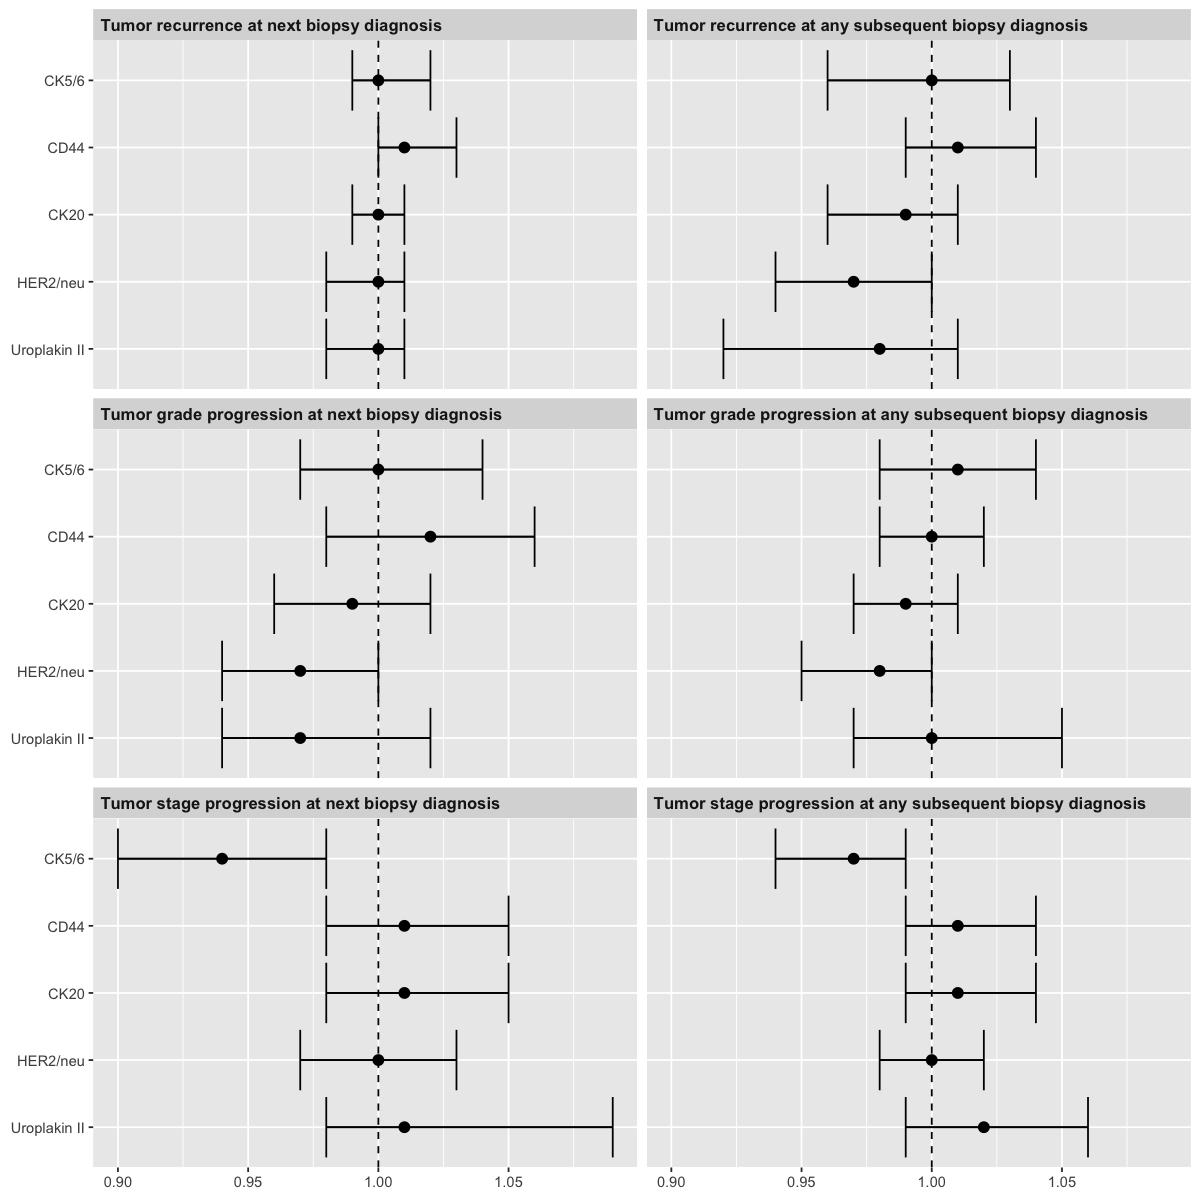

In [116]:
options(repr.plot.width = 10, repr.plot.height = 10)

outcome_marker <- outcome_marker %>% 
    mutate(
        outcome = fct_relevel(
            outcome,
            "Tumor recurrence at next biopsy diagnosis",
            "Tumor recurrence at any subsequent biopsy diagnosis",
            "Tumor grade progression at next biopsy diagnosis",
            "Tumor grade progression at any subsequent biopsy diagnosis",
            "Tumor stage progression at next biopsy diagnosis",
            "Tumor stage progression at any subsequent biopsy diagnosis"
        ),
        marker = fct_relevel(
            marker,
            "CK5/6",
            "CD44",
            "CK20",
            "HER2/neu",
            "Uroplakin II"            
        ),
        marker = fct_rev(marker)
    )

OR_Plot <- ggplot(outcome_marker, aes(x = marker, y = or, ymin = conf.low, ymax = conf.high)) +
    geom_pointrange() +
    geom_errorbar(aes(ymin = conf.low, ymax = conf.high)) +
    geom_hline(yintercept = 1, linetype = 2) +
    facet_wrap(~ outcome, ncol = 2) +
    coord_flip() +
    labs(x = NULL, y = NULL) +
    theme(
        strip.text.x = element_text(face = "bold", hjust = 0, size = 10)
    )

OR_Plot

In [117]:
ggsave(
  filename = "Figs/BL-NMIBUC-OR.png",
  plot = OR_Plot,
  width = 10,
  height = 10,
  units = "in"
)